In [1]:
import pandas as pd
import numpy as np
import plotly.express as go
import glob

In [2]:
df = pd.read_csv("Traffic_Accident_Locations.csv")
df.head()

,X,Y,OBJECTID,AccidentID,DateTimeOccurred,TimeOccurred,DayOfWeek,County,AgencyCode,City,...,LightingCondition,WeatherCondition,TrafficFlow,SupplementalReportTaken,PDUnit,PDDivision,PDShift,PDZone,PDDistrict,PrivateProperty
0,-84.252708,34.024208,1,2201003784,2016/08/26 11:41:00+00,11:41,Friday,FULTON,JCPD,JOHNS CREEK,...,Daylight,Clear,Two-way Traffic-way With No Physical Separation,(no data),JCPD,UN,A,JOHNS CREEK 7,JOHNS CREEK PD SOUTH DISTRICT,(no data)
1,-84.131760,34.056503,2,2019005453,2019/12/09 20:31:00+00,20:31,Monday,FULTON,JCPD,JOHNS CREEK,...,Dark - Lighted,Cloudy,(no data),(no data),JCPD,UN,C,JOHNS CREEK 2,JOHNS CREEK PD NORTH DISTRICT,(no data)
2,-84.195892,34.002357,3,2019005451,2019/12/09 19:02:00+00,19:02,Monday,FULTON,JCPD,JOHNS CREEK,...,Daylight,Clear,(no data),(no data),JCPD,UN,C,JOHNS CREEK 4,JOHNS CREEK PD SOUTH DISTRICT,(no data)
3,-84.190018,34.018135,4,2019005450,2019/12/09 18:04:00+00,18:04,Monday,FULTON,JCPD,JOHNS CREEK,...,Dark - Lighted,Cloudy,(no data),(no data),JCPD,UN,C,JOHNS CREEK 4,JOHNS CREEK PD NORTH DISTRICT,(no data)
4,-84.212708,34.064686,5,2019005446,2019/12/09 13:08:00+00,13:08,Monday,FULTON,JCPD,JOHNS CREEK,...,Daylight,Cloudy,(no data),(no data),JCPD,UN,A,JOHNS CREEK 1,JOHNS CREEK PD NORTH DISTRICT,(no data)


In [3]:
df = df.drop(columns=["AccidentID","County","AgencyCode","City","AddressOrStreetName",
                "geox","geoy","CaseNumber","RoadType","RoadCharacter","SupplementalReportTaken","PDUnit",
                "PDDivision","PDShift","PDDistrict","PrivateProperty"], axis=1)

In [4]:
df[["Day","Time"]] = df["DateTimeOccurred"].str.split(" ",expand=True)

In [5]:
df = df[["OBJECTID",'Day', 'TimeOccurred','X', 'Y','DayOfWeek','UnitsInvolved', 'RoadLanes', 'RoadSurface', 'RoadDefects','LocationOfImpact', 'MannerOfCollision', 'LightingCondition',
        'WeatherCondition', 'TrafficFlow', 'PDZone']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23180 entries, 0 to 23179
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   OBJECTID           23180 non-null  int64  
 1   Day                23180 non-null  object 
 2   TimeOccurred       23180 non-null  object 
 3   X                  23180 non-null  float64
 4   Y                  23180 non-null  float64
 5   DayOfWeek          23180 non-null  object 
 6   UnitsInvolved      23180 non-null  int64  
 7   RoadLanes          23180 non-null  int64  
 8   RoadSurface        23180 non-null  object 
 9   RoadDefects        23180 non-null  object 
 10  LocationOfImpact   23180 non-null  object 
 11  MannerOfCollision  23180 non-null  object 
 12  LightingCondition  23180 non-null  object 
 13  WeatherCondition   23180 non-null  object 
 14  TrafficFlow        23180 non-null  object 
 15  PDZone             21134 non-null  object 
dtypes: float64(2), int64(3

Since I don`t have missing coordinates, it`s possible to generate thte PDZone Using KNN Technique by getting the nearest coordinate and imput the same PDZone

** Haversine’s Equation **

In [7]:
df_missing_PD = df[df["PDZone"].isna()]

In [8]:
df_PD_ok = df[~df["PDZone"].isna()]

In [9]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [10]:
def find_nearest(lat, long):
    distances = df_PD_ok.apply(
        lambda row: dist(lat, long, row['X'], row['Y']), 
        axis=1)
    return df_PD_ok.loc[distances.idxmin(), 'OBJECTID']

In [11]:
if len(glob.glob("./complete_df.csv"))> 0:
    df_completed = pd.read_csv("complete_df.csv")
else:
    df_missing_PD['name'] = df_missing_PD.apply(
        lambda row: find_nearest(row['X'], row['Y']), 
        axis=1)
    # To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
    reference = df_PD_ok[["OBJECTID",'PDZone']]
    df_missing_PD = df_missing_PD.merge(reference,
        left_on='name', 
        right_on='OBJECTID')

    df_missing_PD = df_missing_PD[['OBJECTID_x', 'Day', 'TimeOccurred', 'X', 'Y', 'DayOfWeek',
        'UnitsInvolved', 'RoadLanes', 'RoadSurface', 'RoadDefects',
        'LocationOfImpact', 'MannerOfCollision', 'LightingCondition',
        'WeatherCondition', 'TrafficFlow', 'PDZone_y']]
    df_missing_PD = df_missing_PD.rename(columns={"OBJECTID_x":"OBJECTID","PDZone_y":"PDZone"})
    df_completed = df_missing_PD.append(df_PD_ok)
    df_completed.to_csv("./complete_df.csv")

In [12]:
df_completed = df_completed.set_index("Day")
df_completed.index = pd.to_datetime(df_completed.index)

In [13]:
df_completed['TimeOccurred'] = pd.to_datetime(df_completed['TimeOccurred'], errors='coerce')
df_completed['period'] = (df_completed['TimeOccurred'].dt.hour % 24 + 4) // 4
df_completed['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [14]:
df_completed.head()

,Unnamed: 0,OBJECTID,TimeOccurred,X,Y,DayOfWeek,UnitsInvolved,RoadLanes,RoadSurface,RoadDefects,LocationOfImpact,MannerOfCollision,LightingCondition,WeatherCondition,TrafficFlow,PDZone,period
Day,,,,,,,,,,,,,,,,,
2019-11-18,0,53,2022-07-10 23:02:00,-84.279762,34.008102,Monday,1,0,Dry,(no data),On Shoulder,Not a Collision With a Motor Vehicle,Dark - Lighted,Clear,(no data),JOHNS CREEK 7,Night
2010-07-13,1,17400,2022-07-10 17:30:00,-84.280487,34.009739,Tuesday,2,0,Wet,No Contributing Factors,On Roadway - Non-Intersection,Rear End,Daylight,Rain,Two-way Traffic-way With No Physical Separation,JOHNS CREEK 7,Evening
2019-11-15,2,69,2022-07-10 09:10:00,-84.162643,34.026043,Friday,2,0,Wet,(no data),On Roadway - Non-Intersection,Rear End,Daylight,Rain,(no data),JOHNS CREEK 2,Morning
2019-11-14,3,75,2022-07-10 15:33:00,-84.269325,33.985302,Thursday,2,0,Wet,(no data),On Roadway - Non-Intersection,Rear End,Daylight,Cloudy,(no data),JOHNS CREEK 7,Noon
2019-09-08,4,427,2022-07-10 11:32:00,-84.269325,33.985302,Sunday,2,0,Dry,(no data),On Roadway - Roadway Intersection,Rear End,Daylight,Clear,(no data),JOHNS CREEK 7,Morning


In [15]:
df_count_accidents = df_completed.groupby(["Day"])["DayOfWeek"].count().reset_index().sort_values(by='DayOfWeek', ascending=False)

In [16]:
df_count_accidents = df_count_accidents.set_index("Day")
df_count_accidents.index = pd.to_datetime(df_count_accidents.index)


In [28]:
df_count_accidents=df_count_accidents.rename(columns={"DayOfWeek":"Count"}).sort_index()

In [29]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

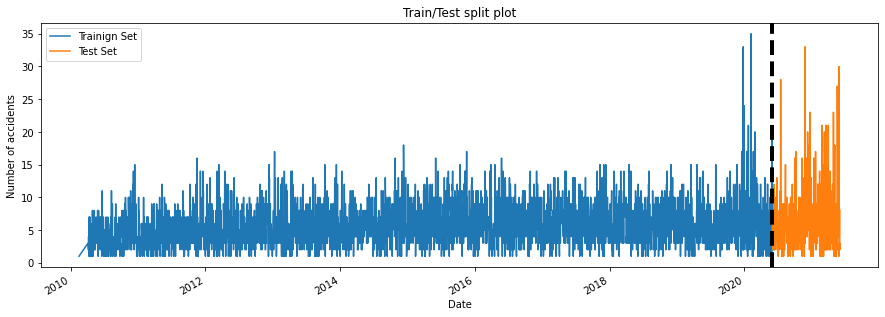

In [35]:


train = df_count_accidents.loc[df_count_accidents.index < '06-01-2020']
test = df_count_accidents.loc[df_count_accidents.index >= '06-01-2020']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = "Train_set", title = "Train/Test split plot")
test.plot(ax=ax, label="Test Data")
plt.ylabel("Number of accidents")
plt.xlabel("Date")
ax.axvline('06-01-2020', color='black', ls="--",linewidth=4)
ax.legend(["Trainign Set", "Test Set"])
plt.show

In [33]:
df_count_accidents

,Count
Day,
2010-02-16,1
2010-04-06,3
2010-04-07,3
2010-04-08,2
2010-04-09,4
...,...
2021-05-27,30
2021-05-28,1
2021-05-31,3
